In [1]:
# Cell 1: Imports and Setup

import numpy as np
import torch
import pickle
import os
# import requests  # If calling the API, but for now, we'll simulate retrieval

base_dir = "../AI-Model-Artifacts/"
scaler_path = os.path.join(base_dir, "MinMax_Scaler.pkl")
model_path = os.path.join(base_dir, "multi_vanilla_patchtst.pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [4]:
import sys
import os

# Add project root to sys.path
project_root = os.path.abspath("..")    # if notebook is inside a folder such as /notebooks
sys.path.append(project_root)


In [8]:
# Cell 2: Step 1 - Retrieve the Data

# Simulate retrieving last 1200 documents from MongoDB via API or direct access
# For testing, assume we have the data; in real use, call /sensor/last-lookback

from configs.mongodb_config import get_database

db = get_database()
if db:
    collection = db["hourly_means"]
    # Retrieve the last 1200 documents, sorted by _id descending
    retrieved_docs = list(collection.find().sort("_id", -1).limit(1200))
    # Reverse to chronological order (oldest to newest)
    retrieved_docs = retrieved_docs[::-1]
    print(f"Retrieved {len(retrieved_docs)} documents from MongoDB in chronological order.")
    if len(retrieved_docs) < 1200:
        raise ValueError("Not enough documents retrieved (need 1200).")
else:
    raise ConnectionError("Failed to connect to database.")

print(f"Retrieved {len(retrieved_docs)} documents.")


Pinged your deployment. You successfully connected to MongoDB!
Retrieved 1200 documents from MongoDB in chronological order.
Retrieved 1200 documents.


In [12]:
# Cell 3: Step 2 - Extract Features

import pandas as pd

# raw_data = np.array([
#     [doc['temp_body_mean'], doc['temp_shaft_mean'], doc['current_mean'], doc['vibration_mean']]
#     for doc in retrieved_docs
# ])

raw_data = pd.DataFrame([
    [doc['temp_body_mean'], doc['temp_shaft_mean'], doc['current_mean'], doc['vibration_mean']]
    for doc in retrieved_docs
], columns=['temp_body', 'temp_shaft', 'current', 'vibration_magnitude'])  # Match training column names

print(f"Raw data shape: {raw_data.shape}") 


Raw data shape: (1200, 4)


In [13]:
# Cell 4: Step 3 - Handling Outliers (Skipped)
# As per requirements, skip outlier handling for inference inputs.


In [15]:
# Cell 5: Step 4 - Scale the Data
with open(scaler_path, "rb") as f:
    scaler = pickle.load(f)

scaled_data = scaler.transform(raw_data)
# Clip to [0, 1] to match training range
scaled_data = np.clip(scaled_data, 0, 1)
print(f"Scaled data shape: {scaled_data.shape}")  # (1200, 4)
print(f"Scaled data range: {scaled_data.min()} to {scaled_data.max()}")


Scaled data shape: (1200, 4)
Scaled data range: 0.0 to 1.0


f:\### STUDIES ###\# Computer Engineering\Sem_08\# FYP\PROJECT\Workflow\Workflow_Test_1\FYP-Machine-Condition-Prediction\_fyp_wf_1\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [16]:
# Cell 6: Step 5 - Reshape for Model Input

model_input = scaled_data.reshape(1, 1200, 4)
input_tensor = torch.tensor(model_input, dtype=torch.float32)
print(f"Input tensor shape: {input_tensor.shape}")  # (1, 1200, 4)


Input tensor shape: torch.Size([1, 1200, 4])


In [17]:
# Cell 7: Step 6 - Feed to Model and Get Output

model = torch.load(model_path, map_location=device, weights_only=False)
model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(past_values=input_tensor)
    forecast = outputs.prediction_outputs.squeeze().cpu().numpy()

print(f"Forecast shape: {forecast.shape}")  # (240, 4)

# Inverse scale if needed
forecast_orig = scaler.inverse_transform(forecast)
print(f"Inverse scaled forecast shape: {forecast_orig.shape}")


f:\### STUDIES ###\# Computer Engineering\Sem_08\# FYP\PROJECT\Workflow\Workflow_Test_1\FYP-Machine-Condition-Prediction\_fyp_wf_1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Forecast shape: (240, 4)
Inverse scaled forecast shape: (240, 4)


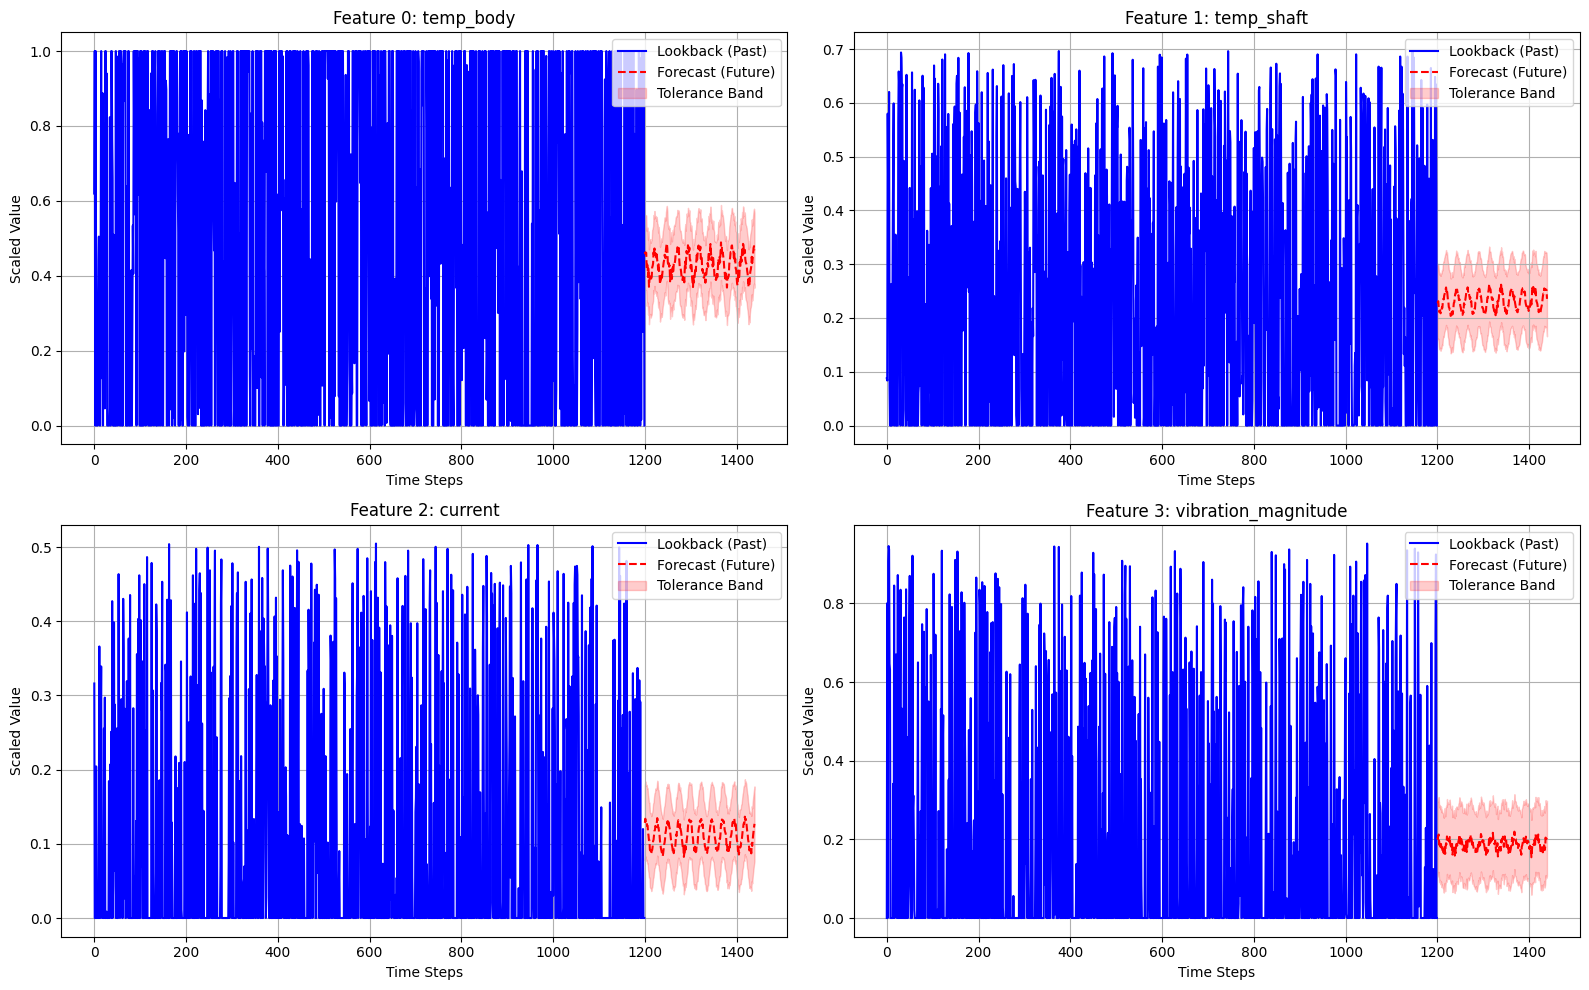

In [ ]:
# Cell 8: Step 7 - Plot Forecast vs. Lookback for Verification

import matplotlib.pyplot as plt

num_features = 4
feature_names = ['temp_body', 'temp_shaft', 'current', 'vibration_magnitude']
lookback = 1200
horizon = 240

plt.figure(figsize=(16, 10))
for feature_idx in range(num_features):
    plt.subplot(2, 2, feature_idx + 1)  # 2x2 grid for 4 features
    
    # Plot the lookback window (last 1200 scaled values)
    plt.plot(range(lookback), scaled_data[:, feature_idx], label='Lookback (Past)', color='blue')
    
    # Plot the forecast (next 240 scaled values)
    plt.plot(range(lookback, lookback + horizon), forecast[:, feature_idx], label='Forecast (Future)', color='red', linestyle='--')
    
    # Add tolerance band (shaded area around forecast) - using 20% of lookback range
    lookback_range = np.max(scaled_data[:, feature_idx]) - np.min(scaled_data[:, feature_idx])
    band_half = 0.1 * lookback_range
    band_lower = forecast[:, feature_idx] - band_half
    band_upper = forecast[:, feature_idx] + band_half
    plt.fill_between(range(lookback, lookback + horizon), band_lower, band_upper, color='red', alpha=0.2, label='Tolerance Band')
    
    plt.title(f'Feature {feature_idx}: {feature_names[feature_idx]}')
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
# Cell 9: Step 8 - Anomaly Score Calculation

# Compute anomaly score based on percentage of forecast points exceeding the max of lookback
num_features = 4
horizon = 240
feature_names = ['temp_body', 'temp_shaft', 'current', 'vibration_magnitude']
at_risk_features = []

for feature_idx in range(num_features):
    forecast_feature = forecast[:, feature_idx]
    
    # Get the max value in the lookback window for this feature
    max_lookback = np.max(scaled_data[:, feature_idx])
    min_lookback = np.min(scaled_data[:, feature_idx])
    
    # Count how many forecast points exceed the max lookback
    num_exceeding_max = np.sum(forecast_feature > max_lookback)
    num_below_min = np.sum(forecast_feature < min_lookback)
    total_anomalous = num_exceeding_max + num_below_min
    
    # Anomaly score as percentage
    anomaly_percentage = (total_anomalous / horizon) * 100
    
    print(f"Feature {feature_idx}: Anomaly % = {anomaly_percentage:.2f}%")
    
    if anomaly_percentage >= -30:
        print("Machine Condition at Risk - Generate Alert + Email")
        at_risk_features.append(feature_names[feature_idx])
    else:
        print("Machine Condition Normal - Generate Alert")

# Determine overall alert message
if at_risk_features:
    overall_at_risk = True
    alert_message = f"Machine at Risk: Stay alert on {', '.join(at_risk_features)}"
else:
    overall_at_risk = False
    alert_message = "Machine Condition Normal"



Feature 0: Anomaly % = 0.00%
Machine Condition at Risk - Generate Alert + Email
Feature 1: Anomaly % = 0.00%
Machine Condition at Risk - Generate Alert + Email
Feature 2: Anomaly % = 0.00%
Machine Condition at Risk - Generate Alert + Email
Feature 3: Anomaly % = 0.00%
Machine Condition at Risk - Generate Alert + Email


In [42]:
# Cell 10: Step 9 - Alert and Email Generation

import os
from sendgrid import SendGridAPIClient
from sendgrid.helpers.mail import Mail
from dotenv import load_dotenv

load_dotenv()

if db:
    collection = db["hourly_means"]
    
    latest_doc = collection.find_one(sort=[("_id", -1)])
    if latest_doc:
        doc_id = latest_doc["_id"]
        
        collection.update_one(
            {"_id": doc_id},
            {"$set": {"alert_message": alert_message}}
        )
        print(f"Alert message '{alert_message}' inserted into the latest document (ID: {doc_id})")
    else:
        print("No documents found in 'hourly_means' collection.")
else:
    print("Database connection failed.")


if overall_at_risk:
    to_email = "aadhiganegoda@gmail.com"
    from_email = "thisupun3@gmail.com"
    subject = "Machine Condition Alert"
    body = alert_message
    
    sendgrid_api_key = os.getenv("SENDGRID_API_KEY")
    if not sendgrid_api_key:
        print("SendGrid API Key not found.")
    else:
        message = Mail(
            from_email=from_email,
            to_emails=to_email,
            subject=subject,
            plain_text_content=body
        )
        try:
            sg = SendGridAPIClient(sendgrid_api_key)
            response = sg.send(message)
            print(f"Email sent successfully. Status code: {response.status_code}")
        except Exception as e:
            print(f"Failed to send email: {str(e)}")
else:
    print("No email sent as machine condition is normal.")



Alert message 'Machine at Risk: Stay alert on temp_body, temp_shaft, current, vibration_magnitude' inserted into the latest document (ID: 69186585618c32199b400a6c)
Email sent successfully. Status code: 202
